In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import haversine as hs

This Jupyter notebook visualizes data about (1) ozone pollution monitor readings vs. the distance of the monitor to a [Superfund site](https://www.epa.gov/superfund) and (2) the frequency of natural disasters in Texas. 

# 0. Superfund site, pollution monitor, & disaster data

In [4]:
# view options and path name
pd.set_option("display.max_columns", 100)

path = os.getcwd()
parent = os.path.dirname(path)

In [4]:
# read in superfund location data
df_loc = pd.read_csv(parent + "/Superfund_data/superfunds_use.csv")

In [5]:
df_loc

,EPA_ID,CITY,STATE,ZIP,CONG DISTRICT,COUNTY,FIPS CODE,LATITUDE,LONGITUDE
0,TX0001399435,PERRYTON,TX,79070,13.0,OCHILTREE,48357,36.400556,-100.804722
1,TX4890110527,PANTEX VILLAGE,TX,79111,13.0,CARSON,48065,35.321944,-101.563611
2,TXSFN0605177,LEVELLAND,TX,79336,19.0,HOCKLEY,48219,33.599883,-102.405561
3,TXD980623904,TEXARKANA,TX,75501,4.0,BOWIE,48037,33.416669,-94.065000
4,TXD008056152,TEXARKANA,TX,75501,14.0,BOWIE,48037,33.408331,-94.053339
...,...,...,...,...,...,...,...,...,...
65,TXD057567216,LIVE OAK,TX,78233,28.0,BEXAR,48029,29.568833,-98.350042
66,TXD089793046,FRIENDSWOOD,TX,77546,22.0,HARRIS,48201,29.568600,-95.204700
67,TXN000606565,SAN ANTONIO,TX,78238,20.0,BEXAR,48029,29.494433,-98.620500
68,TXN000606915,SAN ANTONIO,TX,78253,23.0,BEXAR,48029,29.430489,-98.731875


In [232]:
# read in superfund site construction data
df_date = pd.read_csv(parent + "/Superfund_data/construction_date.csv")

In [233]:
df_date

,EPA_ID,NPL Status,Partial NPL Deletion,Superfund Alternative Approach,Site-wide Ready for Anticipated Use,Construction Complete,Construction Completion Date,Site Status,HRS Score,Non-NPL Status Date
0,TX0000605401,Not NPL,No,No,No,No,NaN,Active,NaN,4/29/00
1,TXN000606636,Not NPL,No,No,No,No,NaN,Active,NaN,8/30/05
2,TXN000605315,Not NPL,No,No,No,No,NaN,Active,NaN,5/5/16
3,TXN000606625,Not NPL,No,No,No,No,NaN,Active,NaN,7/28/05
4,TXD007333743,Not NPL,No,No,No,No,NaN,Active,NaN,3/6/08
...,...,...,...,...,...,...,...,...,...,...
445,TXN000605682,Not NPL,No,No,No,No,NaN,Active,NaN,10/5/04
446,TX0000605403,Not NPL,No,No,No,No,NaN,Active,NaN,10/1/01
447,TXN000605544,Not NPL,No,No,No,No,NaN,Active,NaN,7/28/17
448,TXN000622176,Not NPL,No,No,No,No,NaN,Active,NaN,9/28/21


In [234]:
df_date["Construction Completion Date"].unique()

array([nan, '9/15/06', '7/23/07', '9/14/98', '4/12/93', '4/28/04',
       '9/30/03', '10/2/03', '12/26/91', '6/9/93', '9/26/94', '8/12/10',
       '9/14/93', '9/29/11', '4/18/88', '9/12/08', '6/29/92', '8/20/02',
       '9/24/02', '6/29/18', '8/31/09', '9/30/97', '8/31/11', '3/16/94',
       '9/9/94', '9/28/07', '7/29/09', '9/28/92', '9/30/10', '6/21/22',
       '9/29/05', '9/28/04', '5/1/06', '1/30/95', '9/29/93', '9/15/00',
       '9/29/03', '6/22/07', '9/1/09', '9/14/92', '9/20/04', '9/21/12',
       '9/27/90', '9/30/99'], dtype=object)

In [235]:
# clean date format
for ind, row in df_date.iterrows():
    if pd.isnull(row["Construction Completion Date"]):
        continue

    split = row["Construction Completion Date"].split("/")

    new_split = []

    for i in range(len(split)):
        new_split.append(split[i].zfill(2))

    df_date.loc[ind, "Construction Completion Date"] = "-".join(new_split)

df_date["Construction Completion Date"] = pd.to_datetime(df_date["Construction Completion Date"], format = "%m-%d-%y")

In [236]:
df_date["Construction Completion Date"].unique()

<DatetimeArray>
[                'NaT', '2006-09-15 00:00:00', '2007-07-23 00:00:00',
 '1998-09-14 00:00:00', '1993-04-12 00:00:00', '2004-04-28 00:00:00',
 '2003-09-30 00:00:00', '2003-10-02 00:00:00', '1991-12-26 00:00:00',
 '1993-06-09 00:00:00', '1994-09-26 00:00:00', '2010-08-12 00:00:00',
 '1993-09-14 00:00:00', '2011-09-29 00:00:00', '1988-04-18 00:00:00',
 '2008-09-12 00:00:00', '1992-06-29 00:00:00', '2002-08-20 00:00:00',
 '2002-09-24 00:00:00', '2018-06-29 00:00:00', '2009-08-31 00:00:00',
 '1997-09-30 00:00:00', '2011-08-31 00:00:00', '1994-03-16 00:00:00',
 '1994-09-09 00:00:00', '2007-09-28 00:00:00', '2009-07-29 00:00:00',
 '1992-09-28 00:00:00', '2010-09-30 00:00:00', '2022-06-21 00:00:00',
 '2005-09-29 00:00:00', '2004-09-28 00:00:00', '2006-05-01 00:00:00',
 '1995-01-30 00:00:00', '1993-09-29 00:00:00', '2000-09-15 00:00:00',
 '2003-09-29 00:00:00', '2007-06-22 00:00:00', '2009-09-01 00:00:00',
 '1992-09-14 00:00:00', '2004-09-20 00:00:00', '2012-09-21 00:00:00',
 '19

In [9]:
# read in misc superfund site data
df_cont = pd.read_csv(parent + "/Superfund_data/contaminants.csv")

In [10]:
df_cont

,SEMS EPA ID,SITE NAME,ADDRESS,COUNTY,FEDERAL FACILITY,NPL STATUS,NON-NPL STATUS,LATITUDE/LONGITUDE,CONTAMINANTS
0,TX7572024605,AIR FORCE PLANT #4 (GENERAL DYNAMICS),"GRANTS LANE, FORT WORTH, TX 76108",TARRANT,Y,F,NaN,32.777781/-97.450000,27
1,TXD008123168,ALCOA (POINT COMFORT)/LAVACA BAY,"Postal Address is unavailable for the Site, PO...",CALHOUN,N,F,NaN,28.650833/-96.562222,10
2,TXN000606565,BANDERA ROAD GROUND WATER PLUME,"INTERSECTION OF BANDERA ROAD AND, SAN ANTONIO,...",BEXAR,N,F,NaN,+29.494433/-98.620500,13
3,TX0000605264,BRINE SERVICE COMPANY,"NORTHEAST OF INTERSECTION AT IH-37 AND , CORPU...",NUECES,N,F,NaN,27.815372/-97.508606,0
4,TXN000606965,CIRCLE COURT GROUND WATER PLUME,"117 CIRCLE COURT, WILLOW PARK, TX 76087",PARKER,N,F,NaN,32.744778/-097.679763,0
...,...,...,...,...,...,...,...,...,...
58,TX0002369072,TROPICANA ENERGY COMPANY,"419 SOMERSET ROAD, SAN ANTONIO, TX 78211",BEXAR,N,A,NaN,29.371025/ -98.537439,0
59,TXD980745574,UNITED CREOSOTING CO.,"2ND & HILBIG, CONROE, TX 77301",MONTGOMERY,N,F,NaN,30.331669/-95.456669,10
60,TXN000607093,US OIL RECOVERY,"400 AND 200 N. RICHEY STREET, PASADENA, TX 77506",HARRIS,N,F,NaN,29.718389/-95.221528,0
61,TXD007357932,VAN DER HORST USA CORPORATION,"410 AND 419 EAST GROVE STREET, TERRELL, TX 75160",KAUFMAN,N,F,NaN,32.734167/-96.273889,19


In [11]:
# read in pollution monitor data
monitors = pd.read_csv(parent + "/Pollution_data/aqs_monitors.csv")

/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/844414209.py:1: DtypeWarning: Columns (0,30) have mixed types. Specify dtype option on import or set low_memory=False.
  monitors = pd.read_csv(parent + "/Pollution_data/aqs_monitors.csv")


In [12]:
# generate unique ID for each monitor
monitors["Mon_ID"] = monitors["State Code"].astype(str) + monitors["County Code"].astype(str).str.zfill(3) + monitors["Site Number"].astype(str).str.zfill(4) + monitors["Parameter Code"].astype(str) + monitors["POC"].astype(str)

In [13]:
# find ozone monitors in TX
mask = (monitors["State Code"] == 48) & (monitors["Parameter Code"] == 44201)
tx_ozone = monitors.loc[mask, :].reset_index(drop = True)

In [5]:
# read in natural disaster data
disasters = pd.read_csv(parent + "/Pollution_data/DisasterDeclarationsSummaries.csv")

# find natural disasters in TX counties
mask = disasters[(disasters["fipsCountyCode"] == 0) | ~(disasters["state"] == "TX")].index
disasters = disasters.drop(mask)

# generate state/county FIPS code
disasters["FIPS"] = disasters["fipsStateCode"].astype(str) + disasters["fipsCountyCode"].astype(str).str.zfill(3)

# get datetime data without hours/minutes/seconds
disasters["incidentBeginDate"] = pd.to_datetime(pd.to_datetime(disasters["incidentBeginDate"]).dt.date)
disasters["incidentEndDate"] = pd.to_datetime(pd.to_datetime(disasters["incidentEndDate"]).dt.date)

# drop natural disasters occurring before pollution monitor data set
mask = disasters[(disasters["incidentBeginDate"].dt.year < 1980)].index
disasters = disasters.drop(mask)

# clean column names
disasters = disasters.loc[:, ["incidentType", "FIPS", "incidentBeginDate", "incidentEndDate"]].rename(columns = {"incidentType": "Disaster", "incidentBeginDate": "Disaster_start", "incidentEndDate": "Disaster_end"})
disasters

,Disaster,FIPS,Disaster_start,Disaster_end
5711,Hurricane,48047,1980-08-11,1980-08-11
5712,Hurricane,48007,1980-08-11,1980-08-11
5713,Hurricane,48215,1980-08-11,1980-08-11
5714,Hurricane,48061,1980-08-11,1980-08-11
5715,Hurricane,48261,1980-08-11,1980-08-11
...,...,...,...,...
62710,Fire,48065,2021-12-15,2021-12-19
62937,Fire,48133,2022-03-17,2022-03-30
62938,Fire,48133,2022-03-17,2022-03-30
62939,Fire,48221,2022-03-20,2022-03-30


In [162]:
disasters["Disaster"].value_counts()

Disaster
Hurricane           1263
Fire                1130
Severe Storm(s)      744
Severe Ice Storm     554
Biological           508
Flood                389
Drought              149
Other                 56
Coastal Storm         42
Tornado               24
Freezing              16
Name: count, dtype: int64

In [181]:
# counties with multiple disasters over timeframe
disasters[disasters["FIPS"].duplicated()]

,Disaster,FIPS,Disaster_start,Disaster_end
6162,Freezing,48061,1983-12-22,1983-12-26
6165,Freezing,48489,1983-12-22,1983-12-26
6177,Freezing,48215,1983-12-22,1983-12-26
6396,Flood,48061,1984-09-16,1984-09-18
6399,Flood,48409,1984-10-30,1984-10-30
...,...,...,...,...
62710,Fire,48065,2021-12-15,2021-12-19
62937,Fire,48133,2022-03-17,2022-03-30
62938,Fire,48133,2022-03-17,2022-03-30
62939,Fire,48221,2022-03-20,2022-03-30


In [163]:
disasters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4875 entries, 5711 to 63007
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Disaster        4875 non-null   object        
 1   FIPS            4875 non-null   object        
 2   Disaster_start  4875 non-null   datetime64[ns]
 3   Disaster_end    4331 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 190.4+ KB


In [357]:
# disasters.to_csv("natural_disasters_1980_2022.csv")

# 1. Calculate distances between pollution monitors and superfund sites

In [164]:
df_loc

,EPA_ID,CITY,STATE,ZIP,CONG DISTRICT,COUNTY,FIPS CODE,LATITUDE,LONGITUDE
0,TX0001399435,PERRYTON,TX,79070,13.0,OCHILTREE,48357,36.400556,-100.804722
1,TX4890110527,PANTEX VILLAGE,TX,79111,13.0,CARSON,48065,35.321944,-101.563611
2,TXSFN0605177,LEVELLAND,TX,79336,19.0,HOCKLEY,48219,33.599883,-102.405561
3,TXD980623904,TEXARKANA,TX,75501,4.0,BOWIE,48037,33.416669,-94.065000
4,TXD008056152,TEXARKANA,TX,75501,14.0,BOWIE,48037,33.408331,-94.053339
...,...,...,...,...,...,...,...,...,...
65,TXD057567216,LIVE OAK,TX,78233,28.0,BEXAR,48029,29.568833,-98.350042
66,TXD089793046,FRIENDSWOOD,TX,77546,22.0,HARRIS,48201,29.568600,-95.204700
67,TXN000606565,SAN ANTONIO,TX,78238,20.0,BEXAR,48029,29.494433,-98.620500
68,TXN000606915,SAN ANTONIO,TX,78253,23.0,BEXAR,48029,29.430489,-98.731875


In [165]:
tx_ozone

,State Code,County Code,Site Number,Parameter Code,Parameter Name,POC,Latitude,Longitude,Datum,First Year of Data,Last Sample Date,Monitor Type,Networks,Reporting Agency,PQAO,Collecting Agency,Exclusions,Monitoring Objective,Last Method Code,Last Method,Measurement Scale,Measurement Scale Definition,NAAQS Primary Monitor,QA Primary Monitor,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Tribe Name,Extraction Date,Mon_ID
0,48,27,1045,44201,Ozone,1,31.122419,-97.431052,WGS84,2013.0,2022-08-31,SLAMS,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,POPULATION EXPOSURE,87.0,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,URBAN SCALE,4 KM TO 50 KM,Y,NaN,Temple Georgia,8406 Georgia Avenue,Texas,Bell,Temple,"Killeen-Temple, TX",NaN,2022-11-14,480271045442011
1,48,27,1047,44201,Ozone,1,31.088002,-97.679734,WGS84,2009.0,2022-08-31,SLAMS,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,POPULATION EXPOSURE,87.0,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,URBAN SCALE,4 KM TO 50 KM,Y,NaN,Killeen Skylark Field,1605 Stone Tree Drive,Texas,Bell,Killeen,"Killeen-Temple, TX",NaN,2022-11-14,480271047442011
2,48,29,1,44201,Ozone,1,29.282183,-98.296123,WGS84,1977.0,1981-05-01,OTHER,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,UNKNOWN,11.0,INSTRUMENTAL - CHEMILUMINESCENCE,NaN,NaN,NaN,NaN,NaN,BARNHARDT RD. CALAVERAS STATE PARK,Texas,Bexar,Not in a city,"San Antonio-New Braunfels, TX",NaN,2022-11-14,480290001442011
3,48,29,32,44201,Ozone,1,29.515090,-98.620166,WGS84,NaN,NaN,SLAMS,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,HIGHEST CONCENTRATION,NaN,-,URBAN SCALE,4 KM TO 50 KM,NaN,NaN,San Antonio Northwest,6655 Bluebird Lane,Texas,Bexar,San Antonio,"San Antonio-New Braunfels, TX",NaN,2022-11-14,480290032442011
4,48,29,32,44201,Ozone,2,29.515090,-98.620166,WGS84,1981.0,2022-07-31,SLAMS,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,MAX OZONE CONCENTRATION; POPULATION EXPOSURE,87.0,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,URBAN SCALE,4 KM TO 50 KM,Y,NaN,San Antonio Northwest,6655 Bluebird Lane,Texas,Bexar,San Antonio,"San Antonio-New Braunfels, TX",NaN,2022-11-14,480290032442012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,48,469,3,44201,Ozone,1,28.836214,-97.005525,NAD83,1989.0,2022-06-30,SLAMS,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,POPULATION EXPOSURE,87.0,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,NEIGHBORHOOD,500 M TO 4KM,Y,NaN,Victoria,106 Mockingbird Lane,Texas,Victoria,Victoria,"Victoria, TX",NaN,2022-11-14,484690003442011
215,48,469,1002,44201,Ozone,1,28.643607,-96.891652,WGS84,1977.0,1977-11-07,OTHER,NaN,US EPA - Region 6,US EPA - Region 6,US EPA - Region 6,NaN,UNKNOWN,11.0,INSTRUMENTAL - CHEMILUMINESCENCE,NaN,NaN,NaN,NaN,NaN,ON THE CHURCH GROUNDS,Texas,Victoria,Not in a city,"Victoria, TX",NaN,2022-11-14,484691002442011
216,48,473,1,44201,Ozone,1,30.094444,-96.065833,WGS84,1990.0,1990-12-31,OTHER,NaN,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,NaN,UNKNOWN,14.0,INSTRUMENTAL - CHEMILUMINESCENCE,NaN,NaN,NaN,NaN,NaN,"TX HWY DEPT VACANT YARD, HWY 290",Texas,Waller,Hempstead,"Houston-The Woodlands-Sugar Land, TX",NaN,2022-11-14,484730001442011
217,48,479,16,44201,Ozone,1,27.579045,-99.523949,WGS84,1996.0,2021-07-23,SLAMS,BORDER GRANT,Texas Commission On Environmental Quality,Texas Commission On Environmental Quality,"Weston Solutions, TX",NaN,POPULATION EXP

In [22]:
# calculate haversine distances
hs_df = pd.DataFrame(hs.haversine_vector(tx_ozone[["Latitude", "Longitude"]], df_loc[["LATITUDE", "LONGITUDE"]], comb = True))

In [23]:
# rename indices, columns after IDs
hs_df.index = list(df_loc["EPA_ID"])
hs_df.columns = list(tx_ozone["Mon_ID"])

In [25]:
hs_df

,480271045442011,480271047442011,480290001442011,480290032442011,480290032442012,480290036442011,480290036442012,480290041442011,480290052442011,480290055442011,480290059442011,480290622442011,480391003442011,480391003442012,480391004442011,480391016442011,480430101442011,480430101442012,480550062442011,480610006442011,480610101442011,480611023442011,480710900442011,480710901442011,480710902442011,480710903442011,480850004442011,480850005442011,480850010442011,480850085442011,481090002442011,481090101442011,481130039442011,481130044442011,481130044442012,481130044442013,481130045442011,481130045442012,481130047442011,481130052442011,481130052442012,481130055442011,481130055442012,481130069442011,481130069442012,481130069442013,481130075442011,481130086442011,481130087442011,481131047442011,...,483550022442011,483550025442011,483550025442012,483550026442011,483611001442011,483611001442012,483611100442011,483670080442011,483670081442011,483739991442011,483739991442019,483750010442011,483751001442011,483819991442011,483819991442019,483970001442011,483970081442011,484090002442011,484090002442012,484230004442011,484230007442011,484390005442011,484390057442011,484390075442011,484391002442011,484391002442012,484391003442011,484392002442011,484392003442011,484392003442012,484393009442011,484393011442011,484530002442011,484530003442011,484530003442012,484530011442011,484530012442011,484530013442011,484530014442011,484530014442012,484530015442011,484530020442011,484530613442011,484570101442011,484690002442011,484690003442011,484691002442011,484730001442011,484790016442011,484970087442011
TX0001399435,664.491801,657.497049,825.397125,792.223031,792.223031,795.316797,795.316797,804.522388,780.985107,808.483475,825.714589,816.876506,964.512544,964.512544,916.242543,957.680652,819.704706,819.704706,773.581438,1209.935350,1191.668474,1171.435302,908.337231,919.166558,927.732657,940.594875,525.662121,516.411678,514.850098,515.965427,622.137318,627.439120,531.241839,536.603411,536.603411,536.603411,532.272705,532.272705,544.318074,543.916285,543.916285,560.785846,560.785846,537.318754,537.318754,537.318754,532.287450,529.734081,548.735318,560.337320,...,1000.407535,1011.128179,1011.128179,1000.481661,959.700207,959.700207,943.899559,487.623332,473.819440,850.643452,850.643452,154.942570,137.021219,186.057789,186.057789,553.317015,558.724955,988.019309,988.019309,668.466045,669.163913,536.373216,532.991877,486.285335,509.202012,509.202012,514.892274,497.240838,503.273040,503.273040,511.067665,537.690436,735.082001,724.353766,724.353766,742.867569,728.039987,737.991532,729.086830,729.086830,743.174573,711.814040,728.463422,884.292526,NaN,913.052494,937.067715,827.898199,988.285813,456.993622
TX4890110527,604.698494,593.355217,738.340603,702.215427,702.215427,706.307739,706.307739,715.707413,692.292057,720.360343,738.427577,729.724336,910.203899,910.203899,866.569029,902.824364,686.256865,686.256865,695.720470,1118.189612,1100.526849,1078.679565,867.549499,877.322428,890.720169,900.344014,507.439704,502.080114,509.421166,506.333699,485.608030,490.773252,509.376059,514.107719,514.107719,514.107719,512.726107,512.726107,522.062378,518.718064,518.718064,535.599767,535.599767,514.758759,514.758759,514.758759,512.722402,512.397915,522.946937,541.544007,...,914.989529,926.644802,926.644802,915.026891,933.251090,933.251090,917.663289,446.370417,433.350677,822.162716,822.162716,24.634046,48.936802,49.965644,49.965644,539.421768,546.260035,902.687745,902.687745,656.772521,657.142100,506.557668,504.177092,456.818977,477.896159,477.896159,483.112509,469.042848,475.858707,475.858707,488.814990,507.913246,662.840464,653.144914,653.144914,668.740656,655.981189,665.077541,656.513457,656.513457,670.473066,638.675844,658.786974,857.362428,NaN,839.090950,863.197882,775.889443,882.375331,431.912240
TXSFN0605177,542.293988,524.416243,618.322133,578.637177,578.637177,584.346933,584.346933,593.619503,571.657771,599.296570,617.989902,609.952978,838.454677,838.454677,80

In [26]:
# convert wide format data to long
distances = hs_df.reset_index().melt(id_vars = ["index"]).rename(columns = {"index": "EPA_ID", "variable": "Mon_ID", "value": "Distance"})

In [28]:
distances

,EPA_ID,Mon_ID,Distance
0,TX0001399435,480271045442011,664.491801
1,TX4890110527,480271045442011,604.698494
2,TXSFN0605177,480271045442011,542.293988
3,TXD980623904,480271045442011,406.449837
4,TXD008056152,480271045442011,406.735305
...,...,...,...
15325,TXD057567216,484970087442011,416.111983
15326,TXD089793046,484970087442011,467.774400
15327,TXN000606565,484970087442011,429.410068
15328,TXN000606915,484970087442011,438.847411


In [27]:
# export data
# distances.to_csv("epa_monitors_distances.csv")

In [29]:
# drop observations where monitors are very far away from the superfund site
distances = distances[distances["Distance"] < 25]
distances = distances.reset_index(drop = True)

In [30]:
distances

,EPA_ID,Mon_ID,Distance
0,TXD066379645,480271045442011,7.895495
1,TXD066379645,480271047442011,23.370008
2,TXD057577579,480290032442011,17.786190
3,TXN000606565,480290032442011,2.297184
4,TXN000606915,480290032442011,14.333131
...,...,...,...
643,TXD079348397,484393011442011,24.258549
644,TXD980340889,484393011442011,17.193167
645,TXD988034328,484393011442011,15.704305
646,TXD980699656,484393011442011,23.194914


Text(0, 0.5, 'Count of monitors')

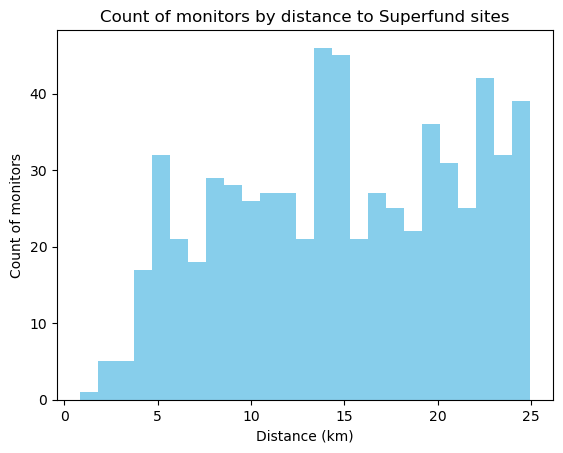

In [180]:
# histogram of monitor distances from superfund sites
plt.hist(distances["Distance"], bins = 25, color = "skyblue")
plt.title("Count of monitors by distance to Superfund sites")
plt.xlabel("Distance (km)")
plt.ylabel("Count of monitors")

# 1.5 Getting annual pollution data

In [32]:
tx_ozone_cropped = tx_ozone[["Mon_ID", "First Year of Data", "Last Sample Date"]]

In [33]:
tx_ozone_cropped

,Mon_ID,First Year of Data,Last Sample Date
0,480271045442011,2013.0,2022-08-31
1,480271047442011,2009.0,2022-08-31
2,480290001442011,1977.0,1981-05-01
3,480290032442011,NaN,NaN
4,480290032442012,1981.0,2022-07-31
...,...,...,...
214,484690003442011,1989.0,2022-06-30
215,484691002442011,1977.0,1977-11-07
216,484730001442011,1990.0,1990-12-31
217,484790016442011,1996.0,2021-07-23


In [237]:
# merge monitor date data and monitor superfund distance data
df = distances.merge(tx_ozone_cropped, how = "left", on = "Mon_ID")

# merge above with fips code data
df = df.merge(df_loc[["EPA_ID", "FIPS CODE"]], how = "left", on = "EPA_ID").rename(columns = {"FIPS CODE": "EPA_FIPS"})
df["EPA_FIPS"] = df["EPA_FIPS"].astype(str)

# merge above with superfund site construction data
df = df.merge(df_date[["EPA_ID", "Construction Completion Date"]], how = "left", on = "EPA_ID")
df["Construction Completion Date"] = df["Construction Completion Date"].dt.year
df["Last Sample Date"] = pd.to_datetime(df["Last Sample Date"], format = "%Y-%m-%d").dt.year
df = df.rename(columns = {"First Year of Data": "Mon_First_Year", "Last Sample Date": "Mon_Last_Year", "Construction Completion Date": "EPA_Construction"})

year_df = df.copy()

# get yearly ozone pollution monitor data from 1980–2022 and merge with df
for i in range(1980, 2023):
    temp = pd.read_csv(parent + f"/Pollution_data/Yearly/annual_conc_by_monitor_{i}.csv")

    # generate unique monitor ID, TX ozone data
    temp["Mon_ID"] = temp["State Code"].astype(str) + temp["County Code"].astype(str).str.zfill(3) + temp["Site Num"].astype(str).str.zfill(4) + temp["Parameter Code"].astype(str) + temp["POC"].astype(str)
    mask = (temp["State Code"] == 48) & (temp["Parameter Code"] == 44201)
    temp = temp.loc[mask, :]

    # use “Ozone 8-hour 2015”/“Daily maximum of 8-hour running average” data
    mask = (temp["Metric Used"] == "Daily maximum of 8-hour running average")
    temp = temp.loc[mask, :]
    temp = temp[["Mon_ID", "Year", "Arithmetic Mean", "Arithmetic Standard Dev"]]
    temp["Year"] = i

    # merge with df
    if i == 1980: 
        year_df = df.merge(temp, how = "outer", on = "Mon_ID")
    else:
        temp = df.merge(temp, how = "outer", on = "Mon_ID")
        year_df = pd.concat([year_df, temp], ignore_index = True)

year_df = year_df.dropna(subset = ["EPA_ID", "Mon_ID", "Distance", "Year", "Arithmetic Mean"])

/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/3858854786.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pollution_data/Yearly/annual_conc_by_monitor_{i}.csv")
/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/3858854786.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pollution_data/Yearly/annual_conc_by_monitor_{i}.csv")
/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/3858854786.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pollution_data/Yearly/annual_conc_by_monitor_{i}.csv")
/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/3858854786.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  te

In [238]:
year_df

,EPA_ID,Mon_ID,Distance,Mon_First_Year,Mon_Last_Year,EPA_FIPS,EPA_Construction,Year,Arithmetic Mean,Arithmetic Standard Dev
12,TXD057577579,480290036442012,14.735983,1978.0,1998.0,48029,NaN,1980.0,0.041802,0.018609
13,TXD057567216,480290036442012,19.611397,1978.0,1998.0,48029,NaN,1980.0,0.041802,0.018609
14,TXN000606565,480290036442012,7.980718,1978.0,1998.0,48029,NaN,1980.0,0.041802,0.018609
15,TXN000606915,480290036442012,20.425208,1978.0,1998.0,48029,2022.0,1980.0,0.041802,0.018609
16,TXD057577579,480290041442011,7.625342,1977.0,1981.0,48029,NaN,1980.0,0.030907,0.017813
...,...,...,...,...,...,...,...,...,...,...
29100,TXD980699656,484392003442012,23.164676,1982.0,2022.0,48439,1992.0,2022.0,0.045854,0.011100
29101,TXD079348397,484393011442011,24.258549,2002.0,2022.0,48113,2004.0,2022.0,0.046099,0.011228
29102,TXD980340889,484393011442011,17.193167,2002.0,2022.0,48113,1993.0,2022.0,0.046099,0.011228
29103,TXD988034328,484393011442011,15.704305,2002.0,2022.0,48113,NaN,2022.0,0.046099,0.011228


In [239]:
# drop duplicates 
mask = year_df[year_df[["EPA_ID", "Mon_ID", "Year"]].duplicated() == True].index
year_df = year_df.drop(mask)
year_df = year_df.reset_index(drop = True)

In [240]:
year_df

,EPA_ID,Mon_ID,Distance,Mon_First_Year,Mon_Last_Year,EPA_FIPS,EPA_Construction,Year,Arithmetic Mean,Arithmetic Standard Dev
0,TXD057577579,480290036442012,14.735983,1978.0,1998.0,48029,NaN,1980.0,0.041802,0.018609
1,TXD057567216,480290036442012,19.611397,1978.0,1998.0,48029,NaN,1980.0,0.041802,0.018609
2,TXN000606565,480290036442012,7.980718,1978.0,1998.0,48029,NaN,1980.0,0.041802,0.018609
3,TXN000606915,480290036442012,20.425208,1978.0,1998.0,48029,2022.0,1980.0,0.041802,0.018609
4,TXD057577579,480290041442011,7.625342,1977.0,1981.0,48029,NaN,1980.0,0.030907,0.017813
...,...,...,...,...,...,...,...,...,...,...
7244,TXD980699656,484392003442012,23.164676,1982.0,2022.0,48439,1992.0,2022.0,0.045854,0.011100
7245,TXD079348397,484393011442011,24.258549,2002.0,2022.0,48113,2004.0,2022.0,0.046099,0.011228
7246,TXD980340889,484393011442011,17.193167,2002.0,2022.0,48113,1993.0,2022.0,0.046099,0.011228
7247,TXD988034328,484393011442011,15.704305,2002.0,2022.0,48113,NaN,2022.0,0.046099,0.011228


In [241]:
year_df = year_df.rename(columns = {"Arithmetic Mean": "Mean_Ozone", "Arithmetic Standard Dev": "SD_Ozone"})

In [242]:
# year_df.to_csv("yearly_distances_ozone_levels.csv")

# 1.5.2 Getting Daily Pollution Data

In [356]:
# check data
pd.read_csv(parent + "/Pollution_data/Daily/daily_44201_1980.csv")

/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/4156346891.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(parent + "/Pollution_data/Daily/daily_44201_1980.csv")


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
0,1,1,2,44201,1,32.428470,-86.443585,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-04-04,Parts per million,NaN,12,71.0,0.047500,0.060,12,67.0,NaN,-,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,Alabama,Autauga,Prattville,"Montgomery, AL",2018-07-20
1,1,1,2,44201,1,32.428470,-86.443585,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-04-05,Parts per million,NaN,17,100.0,0.036588,0.060,10,67.0,NaN,-,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,Alabama,Autauga,Prattville,"Montgomery, AL",2018-07-20
2,1,1,2,44201,1,32.428470,-86.443585,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-04-06,Parts per million,NaN,17,100.0,0.055824,0.065,10,84.0,NaN,-,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,Alabama,Autauga,Prattville,"Montgomery, AL",2018-07-20
3,1,1,2,44201,1,32.428470,-86.443585,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-04-07,Parts per million,NaN,17,100.0,0.043941,0.058,8,61.0,NaN,-,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,Alabama,Autauga,Prattville,"Montgomery, AL",2018-07-20
4,1,1,2,44201,1,32.428470,-86.443585,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-04-08,Parts per million,NaN,17,100.0,0.044235,0.053,19,49.0,NaN,-,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,Alabama,Autauga,Prattville,"Montgomery, AL",2018-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190994,55,141,998,44201,1,44.437188,-89.751233,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-10-27,Parts per million,NaN,17,100.0,0.002000,0.002,7,2.0,NaN,-,NaN,"1400 N. BIRON DRIVE BIRON,WISC.",Wisconsin,Wood,Not in a city,"Wisconsin Rapids-Marshfield, WI",2018-07-19
190995,55,141,998,44201,1,44.437188,-89.751233,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-10-28,Parts per million,NaN,17,100.0,0.002000,0.002,7,2.0,NaN,-,NaN,"1400 N. BIRON DRIVE BIRON,WISC.",Wisconsin,Wood,Not in a city,"Wisconsin Rapids-Marshfield, WI",2018-07-19
190996,55,141,998,44201,1,44.437188,-89.751233,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-10-29,Parts per million,NaN,17,100.0,0.002000,0.002,7,2.0,NaN,-,NaN,"1400 N. BIRON DRIVE BIRON,WISC.",Wisconsin,Wood,Not in a city,"Wisconsin Rapids-Marshfield, WI",2018-07-19
190997,55,141,998,44201,1,44.437188,-89.751233,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,1980-10-30,Parts per million,NaN,17,100.0,0.002000,0.002,7,2.0,NaN,-,NaN,"1400 N. BIRON DRIVE BIRON,WISC.",Wisconsin,Wood,Not in a city,"Wisconsin Rapids-Marshfield, WI",2018-07-19


In [252]:
# merge monitor date data and monitor superfund distance data
df = distances.merge(tx_ozone_cropped, how = "left", on = "Mon_ID")
df = df.merge(df_loc[["EPA_ID", "FIPS CODE"]], how = "left", on = "EPA_ID").rename(columns = {"FIPS CODE": "EPA_FIPS"})
df["EPA_FIPS"] = df["EPA_FIPS"].astype(str)

# merge above with superfund site construction data 
df = df.merge(df_date[["EPA_ID", "Construction Completion Date"]], how = "left", on = "EPA_ID")
df = df.rename(columns = {"First Year of Data": "Mon_First_Year", "Last Sample Date": "Mon_Last_Date", "Construction Completion Date": "EPA_Construction_Date"})

day_df = df.copy()

# get daily ozone pollution monitor data from 1980–2022 and merge with df
for i in range(1980, 2023):
    temp = pd.read_csv(parent + f"/Pollution_data/Daily/daily_44201_{i}.csv")

    # generate unique monitor ID, TX ozone data
    temp["Mon_ID"] = temp["State Code"].astype(str) + temp["County Code"].astype(str).str.zfill(3) + temp["Site Num"].astype(str).str.zfill(4) + temp["Parameter Code"].astype(str) + temp["POC"].astype(str)
    mask = (temp["State Code"] == 48) & (temp["Parameter Code"] == 44201)
    temp = temp.loc[mask, :]
    temp = temp[["Mon_ID", "Date Local", "Arithmetic Mean"]]

    # merge with df
    if i == 1980: 
        day_df = df.merge(temp, how = "outer", on = "Mon_ID")
    else:
        temp = df.merge(temp, how = "outer", on = "Mon_ID")
        day_df = pd.concat([day_df, temp], ignore_index = True)

day_df = day_df.dropna(subset = ["EPA_ID", "Mon_ID", "Distance", "Date Local", "Arithmetic Mean"])
day_df = day_df.reset_index(drop = True)
day_df = day_df.rename(columns = {"Date Local": "Measure_Date", "Arithmetic Mean": "Mean_Ozone"})

/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/2515408896.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pollution_data/Daily/daily_44201_{i}.csv")
/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/2515408896.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pollution_data/Daily/daily_44201_{i}.csv")
/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/2515408896.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pollution_data/Daily/daily_44201_{i}.csv")
/var/folders/0x/p491dqs16dd1x_27x32jxt6h0000gn/T/ipykernel_33474/2515408896.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(parent + f"/Pol

In [253]:
# drop duplicates
mask = day_df[day_df[["EPA_ID", "Mon_ID", "Measure_Date"]].duplicated() == True].index
day_df = day_df.drop(mask)
day_df = day_df.reset_index(drop = True)

In [259]:
# convert dates to datetime data
day_df["Mon_First_Year"] = pd.to_datetime(day_df["Mon_First_Year"].astype(int), format = "%Y")
day_df["Mon_Last_Date"] = pd.to_datetime(day_df["Mon_Last_Date"])
day_df["Measure_Date"] = pd.to_datetime(day_df["Measure_Date"])

In [266]:
day_df

,EPA_ID,Mon_ID,Distance,Mon_First_Year,Mon_Last_Date,EPA_FIPS,EPA_Construction_Date,Measure_Date,Mean_Ozone
0,TXD057577579,480290036442012,14.735983,1978-01-01,1998-08-11,48029,NaT,1980-01-01,0.026647
1,TXD057577579,480290036442012,14.735983,1978-01-01,1998-08-11,48029,NaT,1980-01-02,0.020353
2,TXD057577579,480290036442012,14.735983,1978-01-01,1998-08-11,48029,NaT,1980-01-03,0.013000
3,TXD057577579,480290036442012,14.735983,1978-01-01,1998-08-11,48029,NaT,1980-01-04,0.008824
4,TXD057577579,480290036442012,14.735983,1978-01-01,1998-08-11,48029,NaT,1980-01-05,0.019059
...,...,...,...,...,...,...,...,...,...
2666785,TXD980699656,484393011442011,23.194914,2002-01-01,2022-07-31,48439,1992-09-28,2022-07-11,0.047769
2666786,TXD980699656,484393011442011,23.194914,2002-01-01,2022-07-31,48439,1992-09-28,2022-07-12,0.053000
2666787,TXD980699656,484393011442011,23.194914,2002-01-01,2022-07-31,48439,1992-09-28,2022-07-14,0.029556
2666788,TXD980699656,484393011442011,23.194914,2002-01-01,2022-07-31,48439,1992-09-28,2022-07-15,0.046941


In [267]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666790 entries, 0 to 2666789
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   EPA_ID                 object        
 1   Mon_ID                 object        
 2   Distance               float64       
 3   Mon_First_Year         datetime64[ns]
 4   Mon_Last_Date          datetime64[ns]
 5   EPA_FIPS               object        
 6   EPA_Construction_Date  datetime64[ns]
 7   Measure_Date           datetime64[ns]
 8   Mean_Ozone             float64       
dtypes: datetime64[ns](4), float64(2), object(3)
memory usage: 183.1+ MB


In [268]:
day_df["Measure_Year"] = day_df["Measure_Date"].dt.year

Get number of monitors present in data per year

In [283]:
# get counts of monitor/year pairs
count_df = pd.DataFrame(day_df[["Mon_ID", "Measure_Year"]].value_counts())
count_df = count_df.reset_index()

In [284]:
# check for duplicates
count_df.duplicated().value_counts()

False    1661
Name: count, dtype: int64

In [288]:
# shows number of observations for each monitor/year pair (note count is high due to counting monitor/superfund site pairs together)
count_df

,Mon_ID,Measure_Year,count
0,482011034442012,2000,5124
1,482011034442012,2004,5124
2,482011035442013,2012,5124
3,482011035442013,2011,5110
4,482011034442012,2002,5110
...,...,...,...
1656,482151048442011,2008,64
1657,483550025442012,1981,62
1658,481830001442012,1983,61
1659,480391003442012,1983,50


In [290]:
# count appearance of years in df: should return count of unique monitor IDs associated with each year
to_plot = pd.DataFrame(count_df["Measure_Year"].value_counts()).reset_index()

Text(0.5, 0, 'Year')

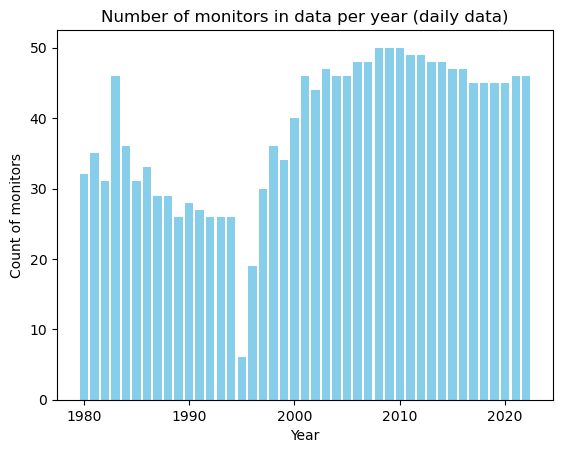

In [292]:
plt.bar(x = to_plot["Measure_Year"], height = to_plot["count"], color = "skyblue")
plt.title("Number of monitors in data per year (daily data)")
plt.ylabel("Count of monitors")
plt.xlabel("Year")

Text(0, 0.5, 'Count of monitor/year combinations')

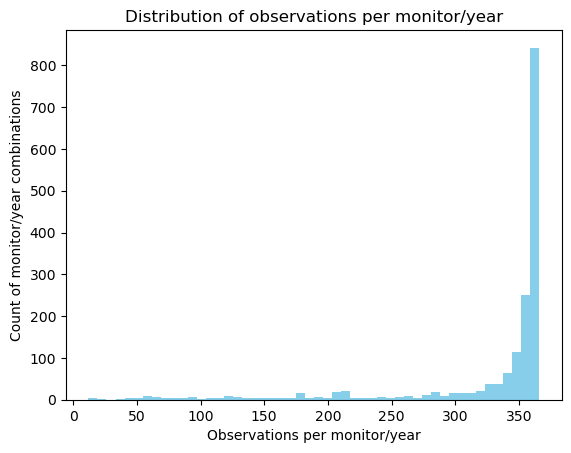

In [306]:
# plot count of observations per monitor per year: find the counts of monitor ID/year/superfund site observations and drop duplicates
# this will find how many times a monitor takes measurments per year as it will drop all but one superfund site from the observations
plt.hist(pd.DataFrame(day_df[["Mon_ID", "Measure_Year", "EPA_ID"]].value_counts()).reset_index()[["Mon_ID", "Measure_Year", "count"]].drop_duplicates()["count"], \
         bins = 50, color = "skyblue")
plt.title("Distribution of observations per monitor/year")
plt.xlabel("Observations per monitor/year")
plt.ylabel("Count of monitor/year combinations")

In [311]:
day_df = day_df.drop(columns = ["Measure_Year"])

In [312]:
# day_df.to_csv("daily_distances_ozone_levels.csv")

# 2. Plotting Ozone Levels over Distances

Text(0.5, 1.0, 'Density of observations (daily ozone monitor measurements) \nby distance from Superfund sites')

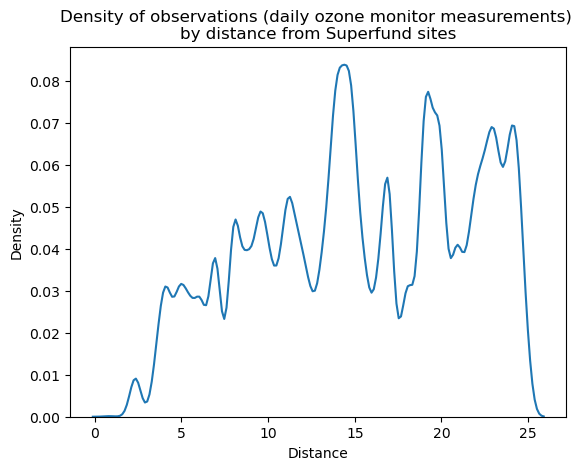

In [328]:
sns.kdeplot(day_df["Distance"])
plt.title("Density of observations (daily ozone monitor measurements) \nby distance from Superfund sites")

Text(0.5, 1.0, 'Mean ozone levels by distance from Superfund sites (daily data)')

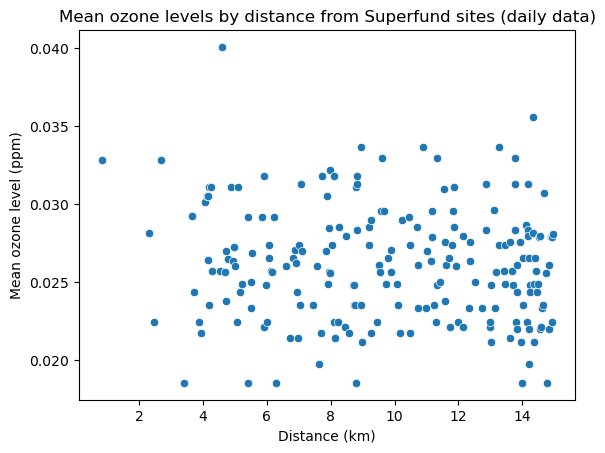

In [332]:
sns.scatterplot(day_df[(day_df["Distance"] < 15)].groupby(by = ["Distance"])["Mean_Ozone"].mean())
plt.xlabel("Distance (km)")
plt.ylabel("Mean ozone level (ppm)")
plt.title("Mean ozone levels by distance from Superfund sites (daily data)")

In [344]:
# observations post construction date
site_open = pd.to_datetime(day_df["EPA_Construction_Date"]) < pd.to_datetime(day_df["Measure_Date"])

Text(0.5, 1.0, 'Density of observations (daily ozone monitor measurements) \nby distance from constructed Superfund sites')

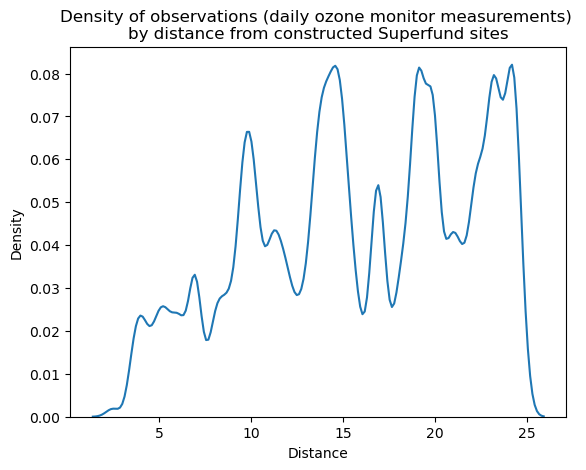

In [347]:
sns.kdeplot(day_df[site_open]["Distance"])
plt.title("Density of observations (daily ozone monitor measurements) \nby distance from constructed Superfund sites")

Text(0.5, 1.0, 'Mean ozone levels by distance \nfrom constructed Superfund sites (daily data)')

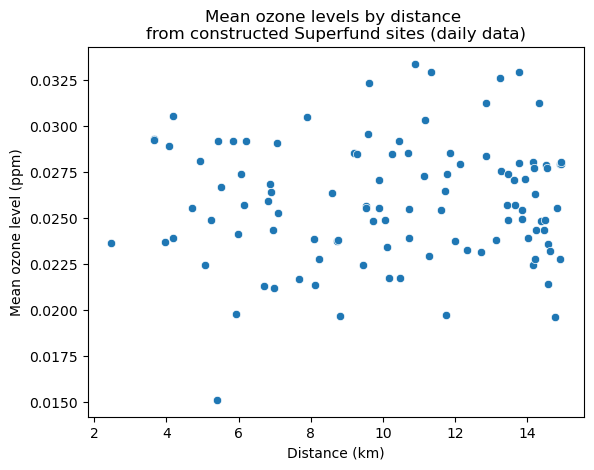

In [348]:
sns.scatterplot(day_df[site_open & (day_df["Distance"] < 15)].groupby(by = ["Distance"])["Mean_Ozone"].mean())
plt.xlabel("Distance (km)")
plt.ylabel("Mean ozone level (ppm)")
plt.title("Mean ozone levels by distance \nfrom constructed Superfund sites (daily data)")

In [349]:
site_closed = pd.to_datetime(day_df["EPA_Construction_Date"]) > pd.to_datetime(day_df["Measure_Date"])

Text(0.5, 1.0, 'Density of observations (daily ozone monitor measurements) \nby distance from not yet constructed Superfund sites')

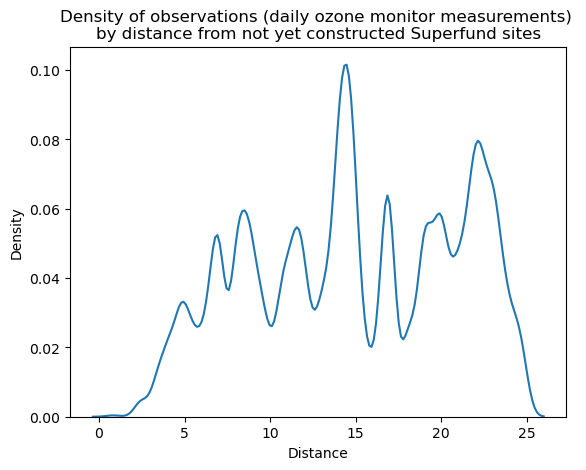

In [350]:
sns.kdeplot(day_df[site_closed]["Distance"])
plt.title("Density of observations (daily ozone monitor measurements) \nby distance from not yet constructed Superfund sites")

Text(0.5, 1.0, 'Mean ozone levels by distance \nfrom not yet constructed Superfund sites (daily data)')

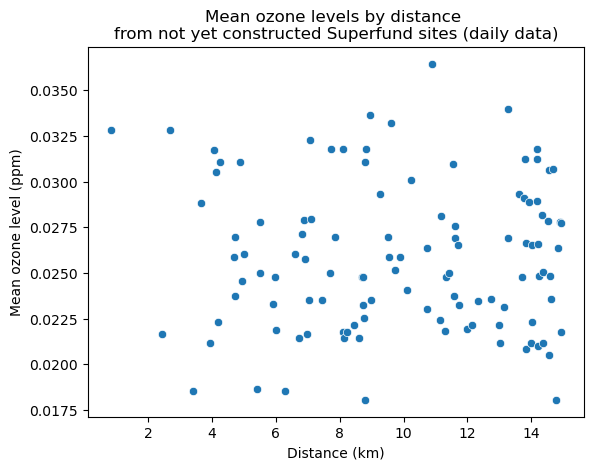

In [351]:
sns.scatterplot(day_df[site_closed & (day_df["Distance"] < 15)].groupby(by = ["Distance"])["Mean_Ozone"].mean())
plt.xlabel("Distance (km)")
plt.ylabel("Mean ozone level (ppm)")
plt.title("Mean ozone levels by distance \nfrom not yet constructed Superfund sites (daily data)")

Text(0.5, 1.0, 'Density of observations (yearly ozone monitor measurements) \nby distance from Superfund sites')

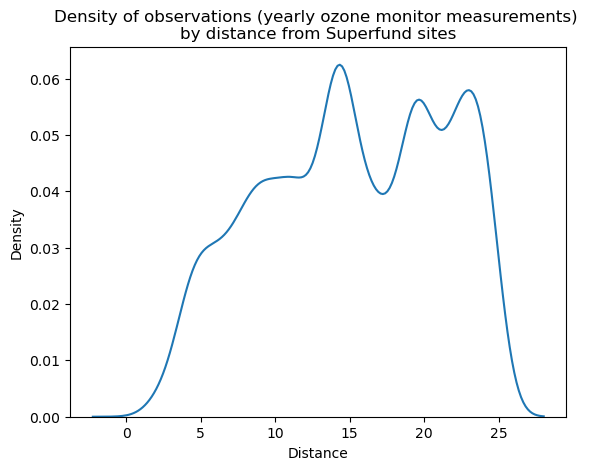

In [352]:
sns.kdeplot(year_df["Distance"])
plt.title("Density of observations (yearly ozone monitor measurements) \nby distance from Superfund sites")

Text(0.5, 1.0, 'Mean ozone levels by distance from Superfund sites (yearly data)')

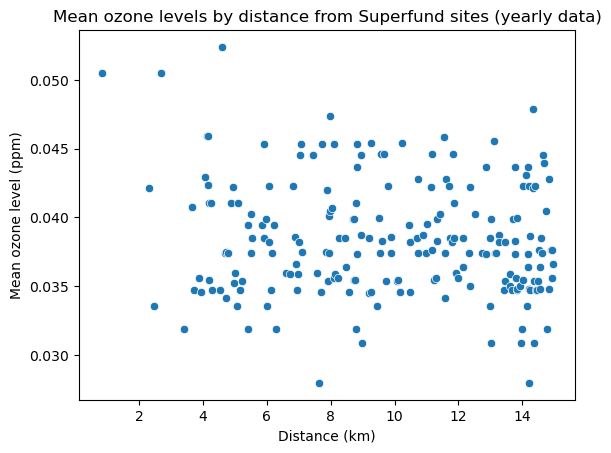

In [338]:
sns.scatterplot(year_df[(year_df["Distance"] < 15)].groupby(by = "Distance")["Mean_Ozone"].mean())
plt.xlabel("Distance (km)")
plt.ylabel("Mean ozone level (ppm)")
plt.title("Mean ozone levels by distance from Superfund sites (yearly data)")

In [353]:
site_open_yr = pd.to_datetime(year_df["EPA_Construction"]) < pd.to_datetime(year_df["Year"])

Text(0.5, 1.0, 'Density of observations (yearly ozone monitor measurements) \nby distance from constructed Superfund sites')

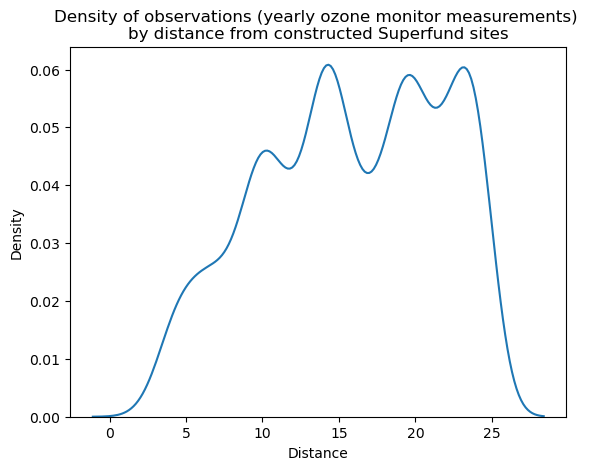

In [339]:
sns.kdeplot(year_df[site_open_yr]["Distance"])
plt.title("Density of observations (yearly ozone monitor measurements) \nby distance from constructed Superfund sites")

Text(0.5, 1.0, 'Mean ozone levels by distance \nfrom constructed Superfund sites (yearly data)')

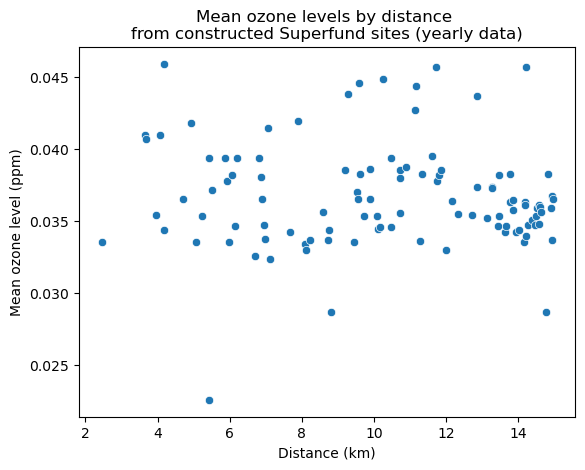

In [342]:
sns.scatterplot(year_df[site_open_yr & (year_df["Distance"] < 15)].groupby(by = "Distance")["Mean_Ozone"].mean())
plt.xlabel("Distance (km)")
plt.ylabel("Mean ozone level (ppm)")
plt.title("Mean ozone levels by distance \nfrom constructed Superfund sites (yearly data)")

In [343]:
site_closed_yr = pd.to_datetime(year_df["EPA_Construction"]) > pd.to_datetime(year_df["Year"])

Text(0.5, 1.0, 'Density of observations (yearly ozone monitor measurements) \nby distance from not yet constructed Superfund sites')

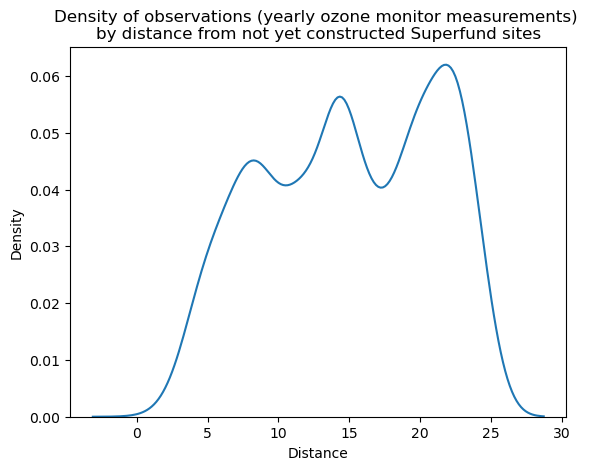

In [354]:
sns.kdeplot(year_df[site_closed_yr]["Distance"])
plt.title("Density of observations (yearly ozone monitor measurements) \nby distance from not yet constructed Superfund sites")

Text(0.5, 1.0, 'Mean ozone levels by distance \nfrom not yet constructed Superfund sites (yearly data)')

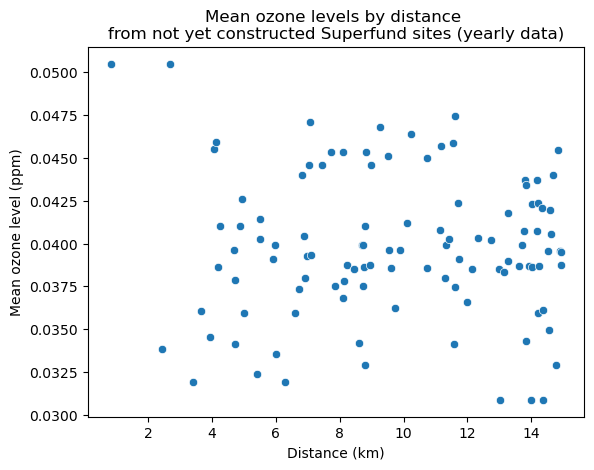

In [355]:
sns.scatterplot(year_df[site_closed_yr & (year_df["Distance"] < 15)].groupby(by = "Distance")["Mean_Ozone"].mean())
plt.xlabel("Distance (km)")
plt.ylabel("Mean ozone level (ppm)")
plt.title("Mean ozone levels by distance \nfrom not yet constructed Superfund sites (yearly data)")

# 3. Plotting Natural Disaster Data

In [6]:
# generate data set containing data for just the top five kinds of natural disasters
top_five = list(pd.DataFrame(disasters["Disaster"].value_counts()[:5]).reset_index()["Disaster"])
top_five_df = disasters[disasters["Disaster"].isin(top_five)]
top_five_df

,Disaster,FIPS,Disaster_start,Disaster_end
5711,Hurricane,48047,1980-08-11,1980-08-11
5712,Hurricane,48007,1980-08-11,1980-08-11
5713,Hurricane,48215,1980-08-11,1980-08-11
5714,Hurricane,48061,1980-08-11,1980-08-11
5715,Hurricane,48261,1980-08-11,1980-08-11
...,...,...,...,...
62710,Fire,48065,2021-12-15,2021-12-19
62937,Fire,48133,2022-03-17,2022-03-30
62938,Fire,48133,2022-03-17,2022-03-30
62939,Fire,48221,2022-03-20,2022-03-30


Text(0.5, 0, 'Disaster start date')

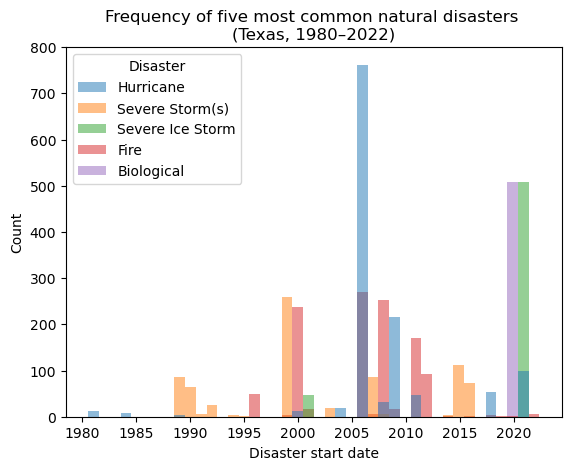

In [8]:
# plot data as bar chart
sns.histplot(data = top_five_df, x = "Disaster_start", hue = "Disaster", bins = 42, edgecolor = None)
plt.title("Frequency of five most common natural disasters \n(Texas, 1980–2022)")
plt.xlabel("Disaster start date")


It may be useful to plot the data geographically. 